# Project- Options 

## Select a stock in order to create an option  

We decided to select the Pfizer stock to create an option. Pfizer is a company that operates in the healthcare sector, which playe an important role during the Covid crisis by distributing the Covid vaccines. We import data for 3 months starting from October,1st, 2023. 

In [1]:
import yfinance as yf

tickerSymbol = 'PFE'
tickerData = yf.Ticker(tickerSymbol)
pfizer_data = tickerData.history(period='1d', start='2000-1-1')
pfizer_adjusted_close = pfizer_data['Close']
print(pfizer_adjusted_close.head())

Date
2000-01-03 00:00:00-05:00    13.061067
2000-01-04 00:00:00-05:00    12.574476
2000-01-05 00:00:00-05:00    12.779359
2000-01-06 00:00:00-05:00    13.240344
2000-01-07 00:00:00-05:00    14.136687
Name: Close, dtype: float64


### Parameters 

In [2]:
import numpy as np
from datetime import datetime, timedelta

# Set the period to three months ago from today
end_date = '2024-01-01'
start_date = '2023-10-01'  # Approximately 3 months

# Fetch historical data for Pfizer
pfizer_data = yf.download('PFE', start=start_date, end=end_date)

# Calculate daily returns
daily_returns = pfizer_data['Adj Close'].pct_change().dropna()

# Calculate the standard deviation of daily returns (daily volatility)
daily_volatility = np.std(daily_returns)

# Annualize the volatility
annualized_volatility = daily_volatility * np.sqrt(252)  # Using 252 trading days

print(f"Annualized Volatility for Pfizer (PFE): {annualized_volatility:.2%}")

# The "T" for our purposes is 0.25 (representing a quarter of a year or three months).

[*********************100%***********************]  1 of 1 completed
Annualized Volatility for Pfizer (PFE): 29.47%


### Black-Scholes approach

The Black-Scholes-Merton (BSM) Option Pricing Model is used to determine the theoretical price of European call and put options. Here are the formulas and components:

- **Call Option Pricing ($C_t$):**

  $$C_t = S_t \cdot N(d_1) - X e^{-rT} \cdot N(d_2)$$

  Where:
  
  - $d_1 = \frac{\ln(\frac{S_t}{X}) + (r + \frac{\sigma^2}{2})T}{\sigma\sqrt{T}}$
  - $d_2 = d_1 - \sigma\sqrt{T}$
  
  And:
  
  - $C_t$ is the current call option price.
  - $S_t$ is the current stock price.
  - $X$ is the strike price of the option.
  - $r$ is the annualized risk-free interest rate.
  - $T$ is the time to expiration in years.
  - $\sigma$ is the annualized volatility of the stock's returns.
  - $N(\cdot)$ denotes the cumulative distribution function (CDF) of the standard normal distribution.

- **Put Option Pricing ($P_t$):**

  $$P_t = X e^{-rT} \cdot N(-d_2) - S_t \cdot N(-d_1)$$

  This formula uses the same variables as the call option pricing formula.

The BSM model assumes a number of factors including constant volatility and interest rates, and it does not account for dividends. It's widely used for its simplicity and the analytical insights it provides into option pricing.


##### Assumptions 

The Black-Scholes-Merton model is a foundational framework in finance for option pricing under specific assumptions. It posits that asset prices follow a lognormal distribution, ensuring they remain positive, and assumes this distribution stems from Geometric Brownian Motion, characterized by constant drift and volatility. The model operates under a no-arbitrage condition, implying there's no possibility for risk-free profit. It also assumes that the underlying asset generates no cash flows like dividends, which simplifies calculations by maintaining a consistent stock price. Market conditions are considered "frictionless," meaning there are no transaction costs, taxes, or restrictions on trading practices like short selling. Finally, the model is tailored for European options, which can only be exercised at expiration, simplifying the pricing compared to American options that can be exercised anytime before expiration.

In [3]:
import pandas as pd

t_bill_data = pd.read_csv('/Users/lucasrouleau/Downloads/DTB3.csv', sep=',', index_col=0)  

print(t_bill_data.head())

            DTB3
DATE            
2023-03-14  4.71
2023-03-15  4.59
2023-03-16  4.57
2023-03-17  4.36
2023-03-20  4.65


In [4]:
# since we're considering a three-month option, we'll use a three-month Treasury bill rate

In [5]:
# Assuming the rates are in a column named 'Rate'
latest_rate = t_bill_data['DTB3'].iloc[1]  # Gets the last item from the 'Rate' column
latest_rate_float = float(latest_rate.replace('%', '').replace(',', ''))  # Remove '%' and ',' before conversion if they exist

# Convert the rate to a decimal (if it's not already)
annualized_risk_free_rate = latest_rate_float / 100.0

print(f"The latest three-month T-Bill rate is: {annualized_risk_free_rate:.2%}")

r = annualized_risk_free_rate

The latest three-month T-Bill rate is: 4.59%


In [6]:
from scipy.stats import norm

# Calculate the mean of the stock's price
mean_price = pfizer_data['Adj Close'].mean()

# Parameters for Black-Scholes
S = pfizer_data['Adj Close'][-1]  # Current stock price: last available price
X = mean_price  # Strike price: mean price over the last three months
T = 0.25  # Time to expiration in years

# Black-Scholes calculations
d1 = (np.log(S/X) + (r + 0.5 * annualized_volatility**2) * T) / (annualized_volatility * np.sqrt(T))
d2 = d1 - annualized_volatility * np.sqrt(T)
call_option_price = (S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2))
call_option_price_BS = call_option_price

print(f"Annualized Volatility for Pfizer (PFE): {annualized_volatility:.2%}")
print(f"Call Option Price: {call_option_price:.2f}")

Annualized Volatility for Pfizer (PFE): 29.47%
Call Option Price: 1.28


### Monte-Carlo approach

#### Geometric Brownian Motion (GBM)

Geometric Brownian Motion (GBM) is a stochastic process that models the logarithmic returns of stock prices as normally distributed. This results in the stock prices themselves being log-normally distributed, ensuring they remain positive. The GBM is defined by the following stochastic differential equation:

$$
dS_t = S_t (\mu dt + \sigma dW_t)
$$

where:
- $S_t$ is the stock price at time $t$,
- $\mu$ is the expected return (drift),
- $\sigma$ is the standard deviation of returns (volatility),
- $dW_t$ is the increment of a Wiener process (Brownian motion).

##### Simulating Stock Prices Using GBM

To perform the Monte Carlo simulation, we need to discretize the GBM equation. For discrete time steps, the stock price can be approximated by the equation:

$$
S_{t+\Delta t} = S_t e^{(\mu - \frac{1}{2} \sigma^2) \Delta t + \sigma \sqrt{\Delta t} Z}
$$

where $Z$ is a standard normal random variable.

##### Estimating the Call Option Price

The price of a call option can be estimated by averaging the payoff at expiration across all simulations. The payoff for a European call option at expiration is calculated as:

$$
\text{payoff} = \max(S_T - X, 0)
$$

where:
- $S_T$ is the simulated stock price at maturity,
- $X$ is the strike price, which is set as the mean of your asset's market price data.

We will perform 7,000 simulations to estimate the call option price.


Estimated Call Option Price: $0.27


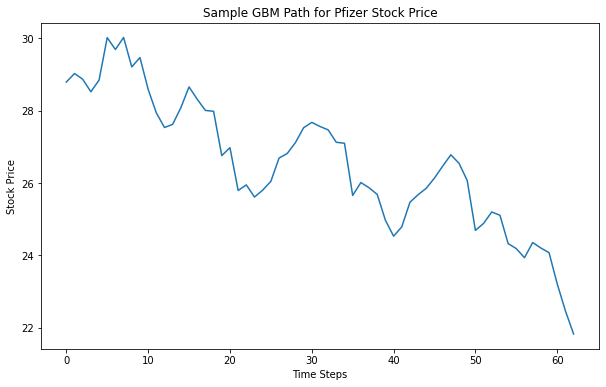

In [7]:
import matplotlib.pyplot as plt
# Monte Carlo simulation parameters
S0 = pfizer_data['Close'].iloc[-1]  # Latest stock price
mu = daily_returns.mean() * 252  # Convert average daily return to annual return
sigma = annualized_volatility
T = 0.25  # Time to maturity in years (3 months)
n = int(T * 252)  # Number of trading days in 3 months
dt = T / n  # Time increment
simulations = 7000

# Simulating the stock price using GBM
Z = np.random.standard_normal((n, simulations))
S = np.zeros_like(Z)
S[0] = S0

for t in range(1, n):
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[t])

# Calculate the payoffs for the call options at maturity
payoffs = np.maximum(S[-1] - X, 0)

# Calculate the mean of the payoffs to estimate the call option price
call_option_price_MC = np.mean(payoffs)
print(f"Estimated Call Option Price: ${call_option_price_MC:.2f}")

# Plotting a sample simulation path
plt.figure(figsize=(10, 6))
plt.plot(S[:, 0])
plt.title('Sample GBM Path for Pfizer Stock Price')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

### Put-Call Parity

Put-call parity is a fundamental principle in options pricing, which establishes a relationship between the prices of European call and put options with the same strike price and expiration date. According to this principle, the price of a put option can be derived using the formula:

$$
P = C - S + X \times e^{-rT}
$$

Where:

- \(P\) is the price of the put option.
- \(C\) is the price of the call option.
- \(S\) is the current stock price.
- \(X\) is the strike price.
- \(r\) is the risk-free interest rate.
- \(T\) is the time to maturity.
- \(e\) is the base of the natural logarithm, representing the exponential function.

#### Parameters Description

- **Put Option Price (\(P\))**: The market price of the put option, which we aim to calculate.
- **Call Option Price (\(C\))**: The known market price of the call option, which shares the same strike price and expiration date as the put option.
- **Stock Price (\(S\))**: The current price of the underlying asset upon which the options are based.
- **Strike Price (\(X\))**: The predetermined price at which the holder of the option can buy (call) or sell (put) the underlying asset.
- **Risk-Free Interest Rate (\(r\))**: The annual interest rate of a theoretically risk-free investment, here based on treasury bills.
- **Time to Maturity (\(T\))**: The remaining lifespan of the option, typically expressed in years.


In [8]:
mean_price = pfizer_data['Adj Close'].mean()
S = pfizer_data['Adj Close'][-1]  # Current stock price: last available price
X = mean_price  # Strike price: mean price over the last three months
T = 0.25  # Time to expiration in years

put_option_price_MC = call_option_price_MC - S + X * np.exp(-r * T)
put_option_price_BS = call_option_price_BS - S + X * np.exp(-r * T)

print(f"Put Option Price from Monte Carlo: ${put_option_price_MC:.2f}")
print(f"Put Option Price from Black-Scholes: ${put_option_price_BS:.2f}")

Put Option Price from Monte Carlo: $1.16
Put Option Price from Black-Scholes: $2.18


In [9]:
import numpy as np

# Assume a final stock price at expiration, which you could also simulate
# Here, we take an example value, or you could use the last simulated price from your Monte Carlo paths
final_stock_price = S  # This could be a simulated or real market value at T

# Calculate payoffs for put options
payoff_put_MC = max(X - final_stock_price, 0)
payoff_put_BS = max(X - final_stock_price, 0)

# Calculate PnL for put options
pnl_put_MC = payoff_put_MC - put_option_price_MC
pnl_put_BS = payoff_put_BS - put_option_price_BS

print(f"Payoff from Monte Carlo Put Option: ${payoff_put_MC:.2f}")
print(f"PnL from Monte Carlo Put Option: ${pnl_put_MC:.2f}")
print(f"Payoff from Black-Scholes Put Option: ${payoff_put_BS:.2f}")
print(f"PnL from Black-Scholes Put Option: ${pnl_put_BS:.2f}")

Payoff from Monte Carlo Put Option: $1.23
PnL from Monte Carlo Put Option: $0.07
Payoff from Black-Scholes Put Option: $1.23
PnL from Black-Scholes Put Option: $-0.94


### Summary of Results
The Black-Scholes model priced the put option significantly higher at `$2.18` compared to the Monte Carlo simulation at `$1.16`. Despite identical payoffs at expiration of `$1.23` for both models, the profit and loss outcomes varied significantly. The Monte Carlo simulation resulted in a small profit of `$0.07`, suggesting the option was potentially undervalued, while the Black-Scholes model led to a notable loss of `-$0.94`, indicating the option was overpriced.

### Key Insights
The Black-Scholes model's sensitivity to inputs like volatility and the risk-free rate can lead to overpricing in uncertain or volatile markets. In contrast, the Monte Carlo simulation may offer more conservative pricing that adapts better to varying market conditions, providing a more realistic scenario analysis. The choice between using Monte Carlo or Black-Scholes models should be guided by considerations of market volatility, risk tolerance, and specific financial goals, as the model selected can significantly affect investment outcomes. The difference in pricing and outcomes underscores the importance of selecting an option pricing model that aligns well with market conditions and personal investment strategies.


### Implied Volatility: Definition and Characteristics

**Definition:**  
Implied volatility is the estimate of future volatility of an asset's price, derived from the market prices of options. It is the volatility parameter (\(\sigma\)) that equates the theoretical price of an option (via the Black-Scholes formula) to its actual market price, representing the market's forecast of potential movement in the asset's price.

**Characteristics:**  
Implied volatility is a market-driven estimate that is not directly observable but inferred from traded option prices. As a forward-looking measure, it contrasts with historical volatility that is based on past price data. This volatility is dynamic, adjusting with market sentiments and the influx of new information. It is generally computed using numerical methods like the Newton-Raphson or Bisection method because a closed-form solution does not exist within the Black-Scholes framework.

High implied volatility suggests a greater uncertainty or risk regarding the underlying asset's future price movement, thus leading to higher option premiums for both calls and puts. This condition reflects the market's anticipation of higher risk of significant price changes that could benefit the option holder. Moreover, the distribution of implied volatility across different strike prices and expiration dates often shows a pattern known as the "volatility smile," where in-the-money and out-of-the-money options exhibit higher volatilities compared to at-the-money options.

### Greeks: Definition and characteristics 

The Greeks represent the variables that are used to measure the impact of parameters on the price of an option. We have the following letters : 

#### Delta 
Delta represents the sensitivity of an option'sprice to the change in price of its underlying asset S.

To compute delta we dvide the change in price of the option by the change in price of the underlying asset. 

A delta of 0.6 means that the price of the option call will chnage by 0.6 dollar for a 1 dollar change in the price of the underlying 

#### Gamma 

Gamma represents the expected change in delta of an option, more specifically it indicates how delta changes as the underlying asset's price evolves.
Gamma is computed as follows :

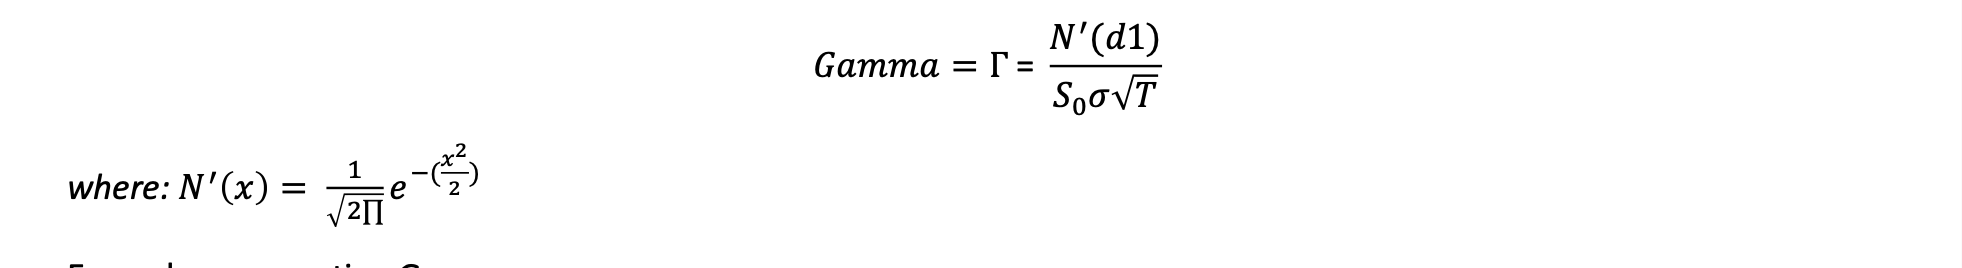

#### Vega: 

Vega measures the sensitivity of an option's price relative to changes in the volatility of the underlying asset. 
For example, a Vega = 3 means that for a 1% increase in volatility, the option's price will grow by 0,03. 


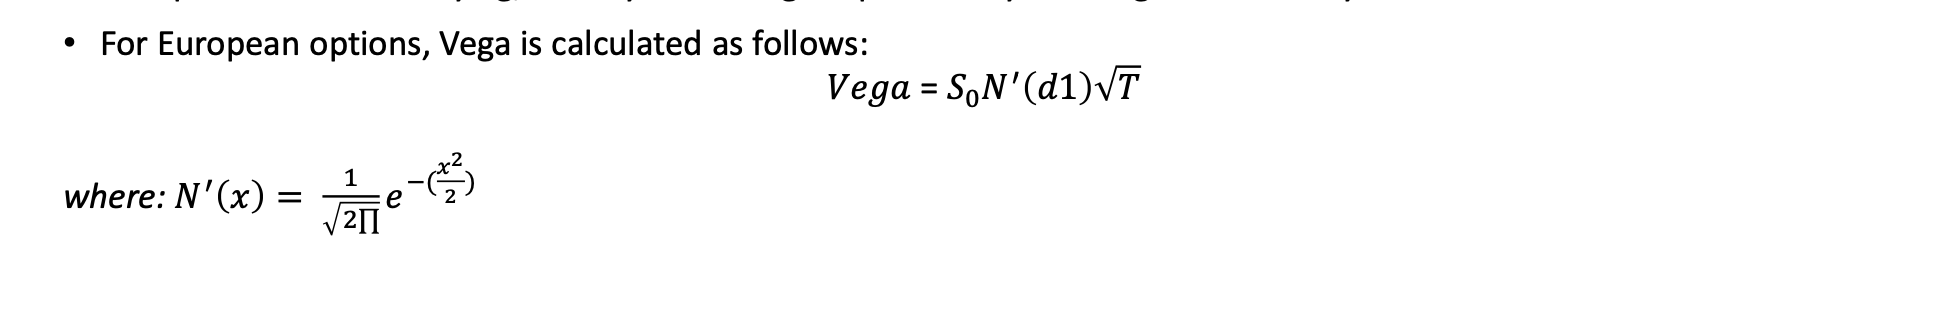

#### Theta : 

Theta represents the change in the price of the option due to a decrease in time to expiration. 
Indeed, for both call and put options, as time passes, most options decrease in value.  
An important feature is that theta is calcuated in years. To find the theta for each trading day, the number has to be divided by the number of traiding days in year. 

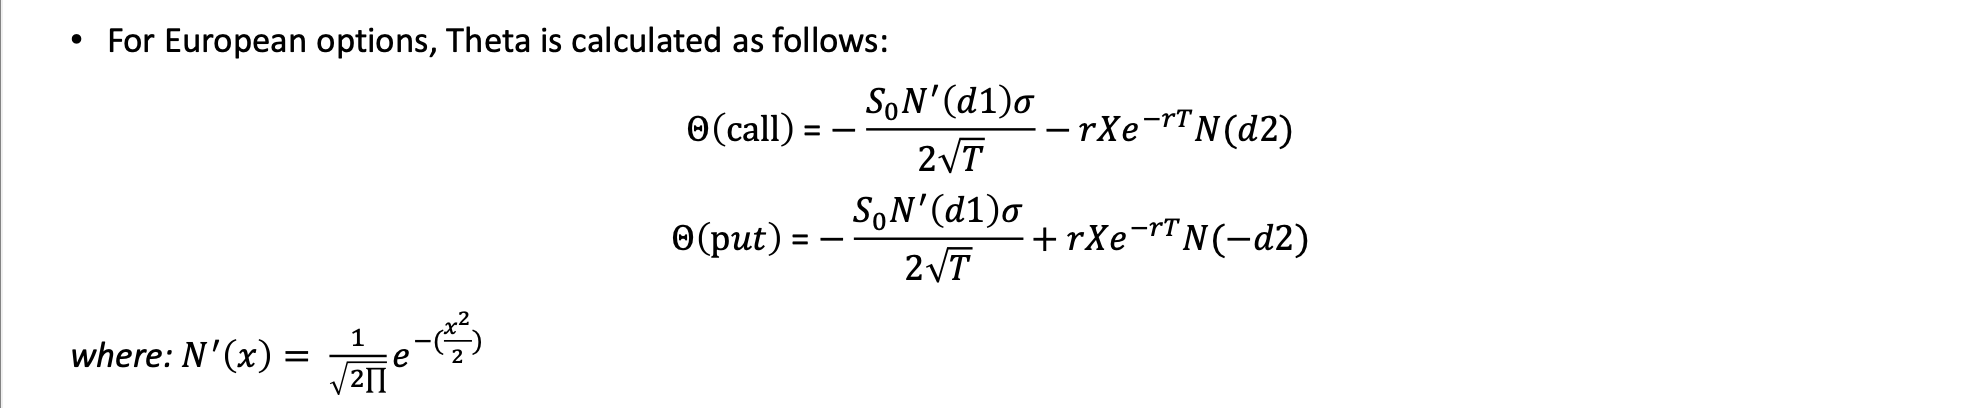

#### Rho: 

Rho indicates the option's sensitivity to changes in the risk-free rate. 
It is important to notice that Equity options are less sensitive to changes in the interest rates than changes in other variables such as the stock price for example. Large changes in those rates have minimal effects on equity option prices. 

For European options, Rho is computed as follows: 

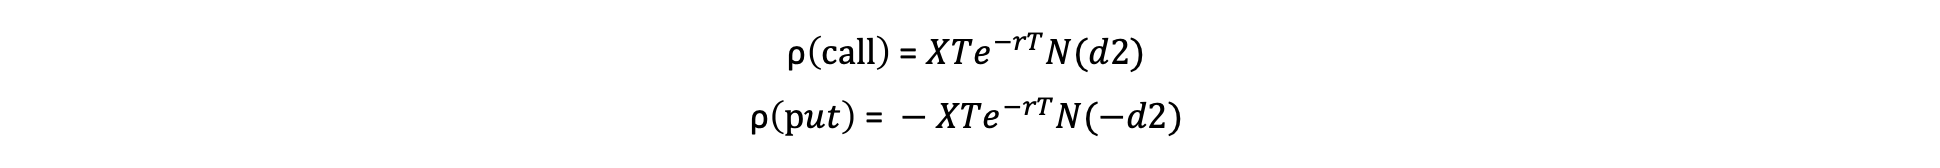

#### For the previously computed call option we compute the Greeks: 

In [10]:
# Greeks calculations
Delta = norm.cdf(d1)
Gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
Daily_Theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - (r * X * np.exp(-r * T) * norm.cdf(d2))/ 365
Vega = S * norm.pdf(d1) * np.sqrt(T)
Rho = X * T * np.exp(-r * T) * norm.cdf(d2)

# Display the results
print(f"Delta: {Delta}")
print(f"Gamma: {Gamma}")
print(f"Daily_Theta : {Daily_Theta}")
print(f"Vega after 3.4% increase in volatility: {Vega * 0.034}")
print(f"Rho with a 1.9% decrease in the risk free rate: {Rho *-0.019}")

Delta: 0.4454362855324085
Gamma: 0.09455656389491407
Daily_Theta : -3.3049961899030538
Vega after 3.4% increase in volatility: 0.19055763550190208
Rho with a 1.9% decrease in the risk free rate: -0.05392198999315733


For these results, we have the following interpretations: 


1)For an increase of 1 dollar of the underlying price, the price of the option will increase by approximatively 0.44 dollars.(Delta)

2)An increase of 1 dollar in the stock price triggers an increase of 0.0946 of delta. (Gamma)

3)The option's price will decrease approximatively by 3.30 dollars per day. (Daily Theta) 

4)For an increase of the volatility of 3.4% of the option, the value of the call option will increase by 0.19. (Vega) 

5)With a decrease of the risk free rate of 1.9% the value of the option will decrease by 0.05. 

## Hedging 

We define hedging as an investment made by an entity/an investor in order to offset or decrease the exposure it has twoards a financial asset. 


The people who use hedging are investors or institutions such as banks in order to proctect their positions from the market risk that cannot be eliminated with diversification. 

We can name several hedging strategies such as Static hedge (without the need to re-balance the hedge depending on the market movements) or dynamic (Need of reajustments because of the market movements) 

In the case of options, hedging strategies are done to protect an option position against adverse movements in the prices or its risk factors.  
There are several hedging approaches when it comes to options:


Delta Hedging: Buying/Sellling the underlying asset in proportion to the option's delta to keep the overall position delta neutral (=0). To do so, the investor can use strategies such as covered call or protective put.   
Gamma hedging: Adjusting the positions by buying/selling options to offset changes in gamma.  
Vega hedging: Hedging against changes in implied volatility involving buying/selling options to neutralize the changes in Vega.  
Theta Hedging: Hedging to minimize the losses due to time. It can involve closing out option positions or adjusting the hedge by buying/selling options to offset the change in theta) 


#### Delta Hedging 

In [11]:
#Asuming holding 25k shares, we compute the number of options to create a delta neutral position, here using a covered call: 
shares_held= 25000

# Since 1 option contract typically represents 100 shares, we divide by 100
contracts_to_sell_delta = shares_held / (Delta *100)

print( contracts_to_sell_delta)

561.2474962635499


In [12]:
contracts_to_sell_delta = 561

The number of call option contracts the investor has to sell to have a delta-netural position is : 561.2474962635499 (561 contracts because it is only possible to sell whole contracts)

In [14]:
#We suppose now that the market price of the asset increases by 1.4 dollar, we want to measure the effect on our delta neutral portfolio 
change_in_stock_price = 1.4  # The change in market price of the asset


# Since we are long in shares, an increase in stock price increases our portfolio delta by the number of shares
change_in_portfolio_delta_shares = shares_held * change_in_stock_price

# For the options position, the delta change is in the opposite direction (since we are short on options)
# So we subtract the change in delta due to options from the change in delta due to shares
change_in_portfolio_delta_options = contracts_to_sell_delta * 100 * Delta * -change_in_stock_price

# The net effect on the delta neutral portfolio
net_effect_on_portfolio = change_in_portfolio_delta_shares + change_in_portfolio_delta_options

net_effect_on_portfolio

15.434134284638276

The effect on the delta neutral position if the market price of the asset increases by 1.4 dollar is an increase of the portfolio's delta by 15.43, meaning an increase of 1.4 dollar of the asset price, the delta neutral portfolio would increase by 15.43 

### Gamma Hedging 

Gamma neutral positions have to be created using instruments that aren't linearly related to the unerlying instrument. To create this situation and protect our portfolio from market risk, we enter a short position for a random option which have the following features:  
Delta value: 0.75
Gamma Value: -0.03


In [15]:
random_option_delta = 0.75 
random_option_gamma = -0.03

#To gamma hedge we want to know how many options we have to buy/sell 

gamma_neutral = -(Gamma/random_option_gamma)

gamma_neutral

3.1518854631638025

In order to gamma-hedge the investor have to buy approximatively 3 options. 

In [16]:
#To recalibrate the delta of the existing portfolio position: 
Quantity_options = random_option_delta* gamma_neutral
print(Quantity_options)

2.363914097372852


Maintaing a delta-gamma neutral position is imposssible because when gamma is modified to be neutral, the quantity of delta in the existing portfolio change because we are increasing the number of options in this position. 

### Vega Hedging

We assume now to have a portfolio position consisting of the call option from 3 b) and of the call option from 4 b), we want to adjust the portfolio to achieve a vega-neutral position. 

A vega-neutral position means that the overall sensitivity of the portfolio's value to changes in implied volatility is minimized or equal to 0. 

In [17]:
#We want to compute the vega of the Call option from the MOnte Carlo approach 
d1_mc = (np.log(S0/X) + (r + 0.5 * annualized_volatility**2) * T) / (annualized_volatility * np.sqrt(T))
Vega_mc = S0 * norm.pdf(d1_mc) * np.sqrt(T)
Vega_mc

5.739087176765276

In [18]:
#We determine the total vega of our portfolio :
total_vega = Vega + Vega_mc


In [19]:
#Since our vega is positive we need to add negative vega compenents to achieve vega neutrality. 
#We assume call options with a vega of -3. We want to determine how many options of these call options we have to sell to achieve vega neutrality 
vega_adjustment= total_vega/-3
vega_adjustment 

-3.7812411716855046

The investor would have to sell approximatively 4 options. Because We have to round this number, we will not obtain vega neutrality but we obtain a vega which is almost neutral. 